# Accuracy for different classes

In this notebook we will look at how accuracy varies for different classes.

In [1]:
import os
import sys
import pathlib
import functools

import pandas
import numpy

In [109]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')
matplotlib.pyplot.style.use('ggplot')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics
import sklearn.inspection

In [4]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [5]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [6]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [7]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [8]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [9]:
root_data_dir

'/data/users/shaddad/xbt-data/'

In [10]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']

In [11]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [12]:
experiment_name = 'nb_single_decisionTree_country'
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [13]:
classifier_opts = {'max_depth': 20,
                   'min_samples_leaf': 1,
                   'criterion': 'gini'
                  }

In [14]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [15]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [16]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [17]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 49 s, sys: 9.99 s, total: 59 s
Wall time: 1min 2s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [18]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 226 ms, sys: 15.3 ms, total: 241 ms
Wall time: 241 ms


In [19]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [20]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 22.6 ms, sys: 1.12 ms, total: 23.7 ms
Wall time: 21.8 ms


In [21]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 10.1 s, sys: 23.1 ms, total: 10.1 s
Wall time: 10.1 s


In [22]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [23]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [24]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 1min 51s, sys: 20.8 s, total: 2min 12s
Wall time: 2min 12s


In [25]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For the model and manufacturer, we train a Decision ree Classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

In [26]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [27]:
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(max_depth=20)

In [28]:
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].classes_)

In [29]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [30]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [31]:
y_res_unseen_instr_all = clf_dt_instr1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [98]:
pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

,target,precision,recall,f1
0,instrument_train,0.974814,0.974705,0.974488
1,instrument_test,0.957517,0.957704,0.957356
2,instrument_unseen,0.929693,0.930803,0.929516


In [32]:
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

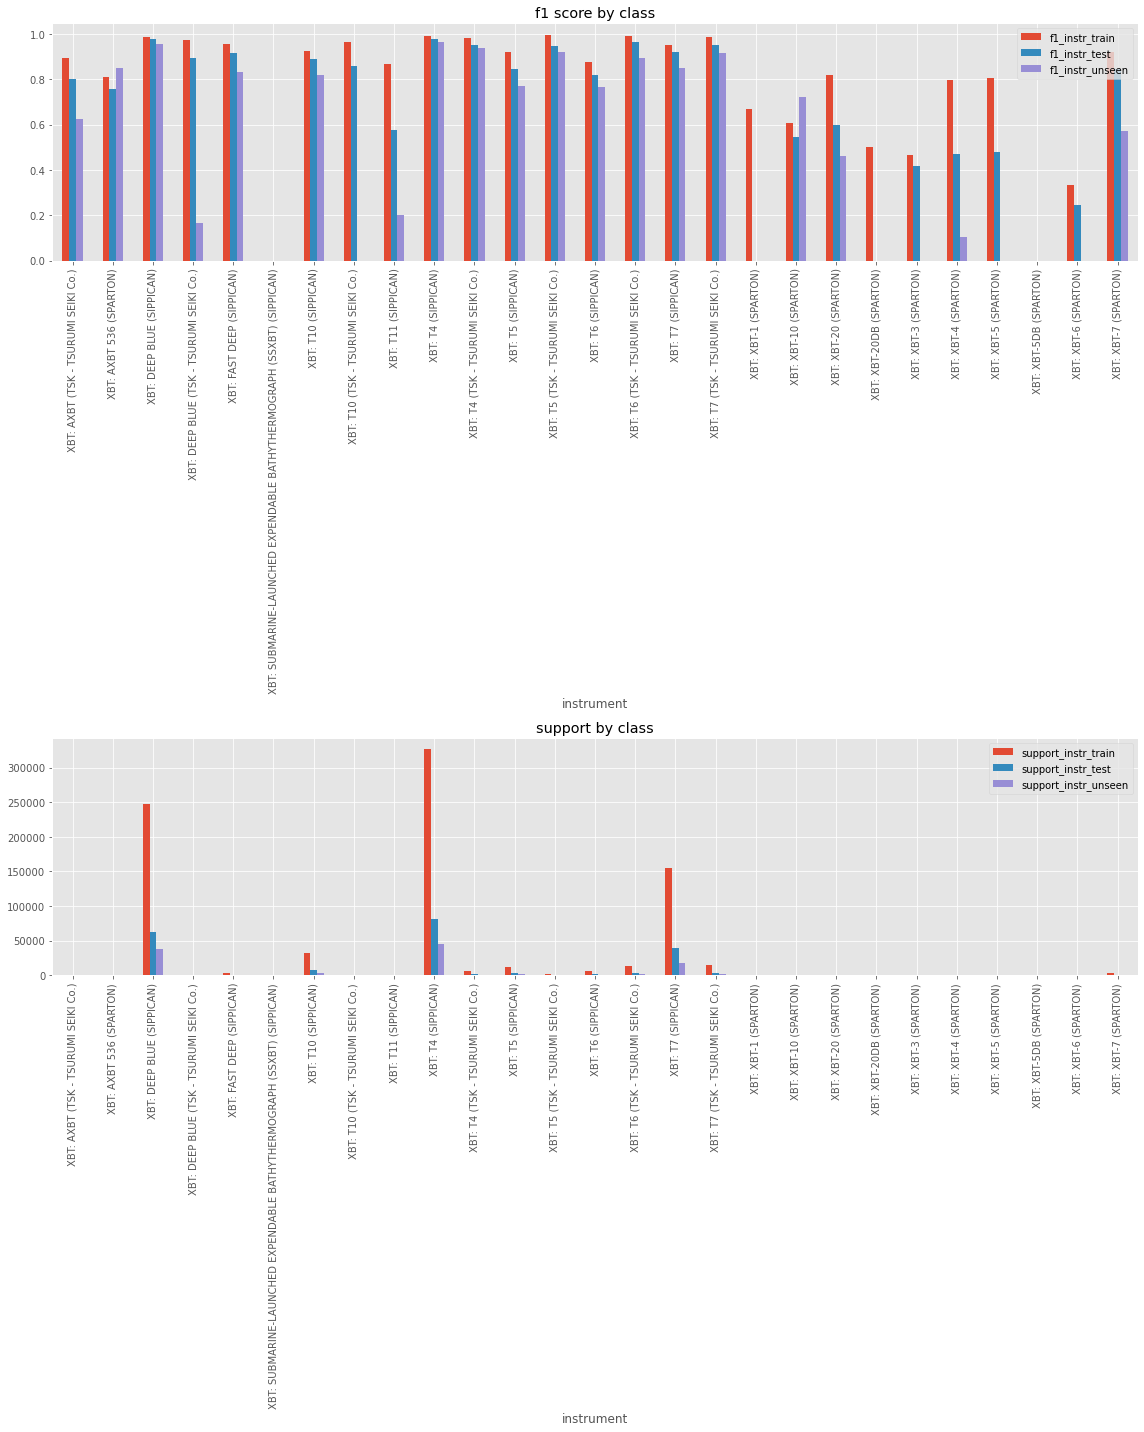

In [108]:
fig1 = matplotlib.pyplot.figure('metrics_by_class', figsize=(16,20))
fig1.set_tight_layout(True)
ax1 = fig1.add_subplot(2,1,1,title='f1 score by class')
_ = df_metrics_per_class_instr.plot.bar(x='instrument',
                                    y=['f1_instr_train', 'f1_instr_test', 'f1_instr_unseen'],
                                    ax=ax1,
                                   )
ax1 = fig1.add_subplot(2,1,2,title='support by class')
_ = df_metrics_per_class_instr.plot.bar(x='instrument',
                                    y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'],
                                    ax=ax1,
                                   )

In [33]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [34]:
def score_subset(xbt_subset,clf, input_features, target_feature):
    X_subset = xbt_subset.filter_features(input_features).get_ml_dataset()[0]
    y_subset = xbt_subset.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_subset = clf.predict(X_subset)
    metric_subset = sklearn.metrics.precision_recall_fscore_support(
        y_subset, y_res_subset, average='micro')
    return metric_subset

In [36]:
num_countries=20

In [37]:
countries_list = (xbt_labelled.xbt_df['country'].value_counts()[:num_countries].index)

In [38]:
countries_metric_df = pandas.DataFrame(
    {'countries': countries_list,
     'support_train': [xbt_train_all.filter_obs({'country': country1}).shape[0] for country1 in countries_list],
     'recall_train': [score_subset(xbt_train_all.filter_obs({'country': country1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for country1 in countries_list],
     'support_test': [xbt_test_all.filter_obs({'country': country1}).shape[0] for country1 in countries_list],
     'recall_test': [score_subset(xbt_test_all.filter_obs({'country': country1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for country1 in countries_list],
     'support_unseen': [xbt_unseen.filter_obs({'country': country1}).shape[0] for country1 in countries_list],
     'recall_unseen': [score_subset(xbt_unseen.filter_obs({'country': country1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for country1 in countries_list],
    })

In [39]:
countries_metric_df

,countries,support_train,recall_train,support_test,recall_test,support_unseen,recall_unseen
0,UNITED STATES,372857,0.981081,93481,0.963511,48201,0.949524
1,AUSTRALIA,64681,0.990507,16301,0.977241,8779,0.942476
2,GREAT BRITAIN,62303,0.986919,15426,0.973357,10108,0.945687
3,JAPAN,56086,0.993849,13918,0.975140,8392,0.951144
4,UNKNOWN,39469,0.909473,9876,0.884164,3248,0.922106
5,LIBERIA,35625,0.958849,8750,0.945486,4980,0.906627
6,GERMANY,28618,0.992557,7045,0.983676,4224,0.924006
7,FRANCE,22781,0.988806,5720,0.956643,2020,0.908911
8,PANAMA,20611,0.956965,5245,0.951764,4275,0.923041
9,CANADA,21199,0.872400,5203,0.834903,2921,0.830195


<AxesSubplot:title={'center':'support by country'}, xlabel='countries'>

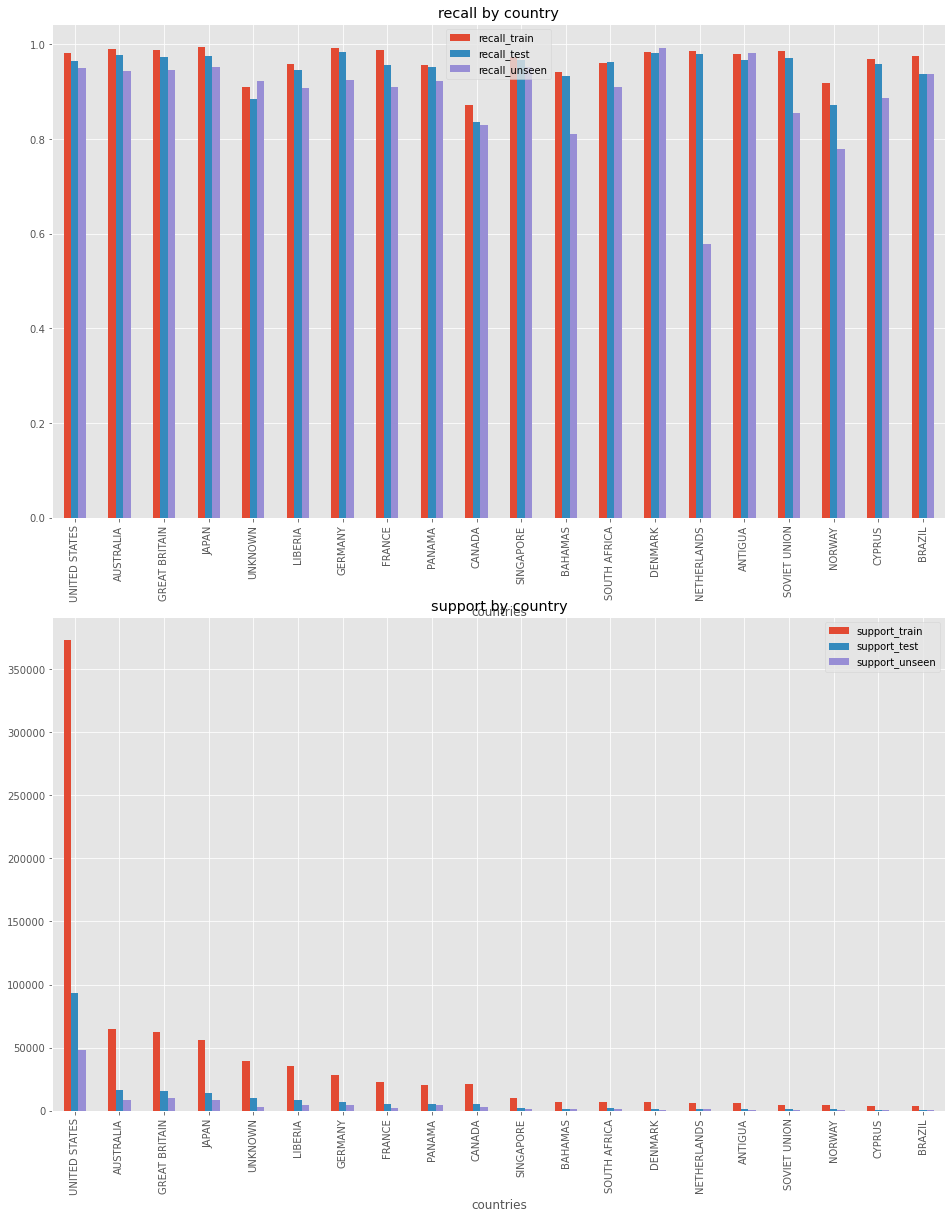

In [110]:
fig1 = matplotlib.pyplot.figure('recall_by_country', figsize=(16,20))
ax1 = fig1.add_subplot(2,1,1, title='recall by country')
countries_metric_df.plot.bar(x='countries', 
                             y=['recall_train','recall_test', 'recall_unseen'],
                             ax=ax1)
ax1 = fig1.add_subplot(2,1,2, title='support by country')
countries_metric_df.plot.bar(x='countries', 
                             y=['support_train','support_test', 'support_unseen'],
                             ax=ax1)

In [100]:
years_metric_df = pandas.DataFrame(
    {'year': list(range(*year_range)),
     'support_train': [xbt_train_all.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)],
     'recall_train': [score_subset(xbt_train_all.filter_obs({'year': year1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for year1 in range(*year_range)],
     'support_test': [xbt_test_all.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)],
     'recall_test': [score_subset(xbt_test_all.filter_obs({'year': year1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for year1 in range(*year_range)],
     'support_unseen': [xbt_unseen.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)],
     'recall_unseen': [score_subset(xbt_unseen.filter_obs({'year': year1}), 
                   clf=clf_dt_instr1, 
                   input_features=input_feature_names,
                   target_feature='instrument',
                  )[0] for year1 in range(*year_range)],
    })

<AxesSubplot:title={'center':'support by year'}, xlabel='year'>

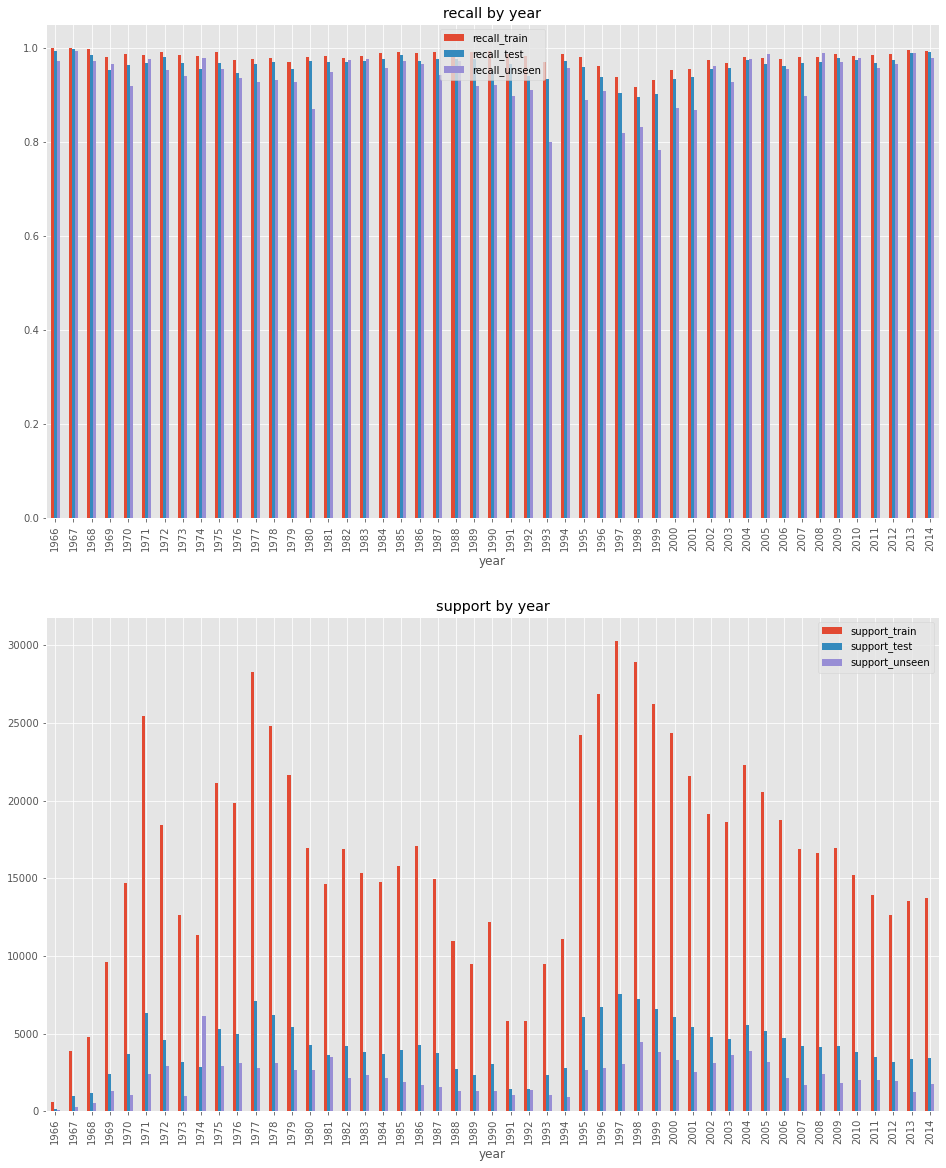

In [111]:
fig1 = matplotlib.pyplot.figure('recall_by_country', figsize=(16,20))
ax1 = fig1.add_subplot(2,1,1, title='recall by year')
years_metric_df.plot.bar(x='year', 
                             y=['recall_train','recall_test', 'recall_unseen'],
                             ax=ax1)
ax1 = fig1.add_subplot(2,1,2, title='support by year')
years_metric_df.plot.bar(x='year', 
                             y=['support_train','support_test', 'support_unseen'],
                             ax=ax1)